In [22]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
#clf = svm.SVC(kernel='linear', C=1)


from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc, font_manager
rc('font',family="NanumSquareR")
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import scipy.stats as st

In [23]:
# colab
# file_path = '/content/drive/MyDrive/kaggle-study/3/Auction_master_kr/'

# jupyter
file_path = './Auction_master_kr/'

train = pd.read_csv(file_path + 'Auction_master_train.csv')
train = train.loc[train['Auction_key'] != 10,]  # 왜 뺏지? -> 나중에 확인해보기
test = pd.read_csv(file_path + 'Auction_master_test.csv')
rent = pd.read_csv(file_path + 'Auction_rent.csv')
regist = pd.read_csv(file_path + 'Auction_regist.csv')
result = pd.read_csv(file_path + 'Auction_result.csv')

In [24]:
# Target값과 관련 확인하기 -> 내가 멋대로 뺀 피처 중에도 영향력있는 것이 있다.
train.corr()['Hammer_price'].sort_values()

Auction_key                   -0.494335
point.x                       -0.357186
Auction_count                 -0.060598
Auction_miscarriage_count     -0.059509
addr_bunji1                   -0.018607
addr_bunji2                    0.000084
road_bunji1                    0.028545
Total_land_gross_area          0.094260
road_bunji2                    0.206681
Claim_price                    0.227550
Current_floor                  0.263951
Total_floor                    0.288378
point.y                        0.357915
Total_land_real_area           0.457389
Total_land_auction_area        0.470488
Total_building_area            0.644298
Total_building_auction_area    0.651966
Total_appraisal_price          0.976729
Minimum_sales_price            0.992170
Hammer_price                   1.000000
Name: Hammer_price, dtype: float64

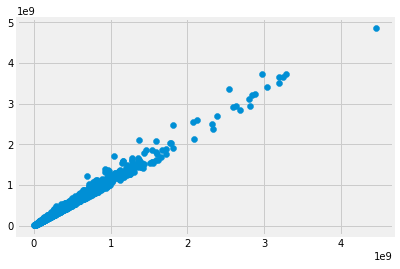

In [25]:
plt.scatter(train['Minimum_sales_price'],train['Hammer_price'])

target(Hammer_price)와 상관관계의 절대값이 높은 것은 Minimum_sales_price라는 변수이다. 그런데 문제는 이 변수와 target과의 상관관계가 높아도 너무 높다(0.99를 넘는다는 것은 엄청 높은 것이다) 이대로 학습을 진행하면, Minimum_sales_price 에 중요도가 매우 높아져, 다른 feature 들의 정보가 묻힐 가능성이 높다고 생각된다. 그러므로 위 정보를 다른 방식으로 사용할 수 있으면 좋을 것이다. Hammer_price >= Minimum_sales_price 일 것이므로, Minimum_sales_price 에 대비해 몇 %(ratio) 를 예측하도록 문제를 바꾸고자 한다. 위 방법을 했을 때의 또 다른 장점은 Hammer_price 는 그 수치의 절대 값이 큰 편이라 variance 가 자연스레 커진다. 하지만 ratio 는 1~2 정도의 수치이므로 variance 가 적기 때문에 좀 더 세밀한 예측을 할 수 있게 된다. 그래서 new_target(real) = Hammer_price/Minimum_sales_price 로 잡고, 예측값에 다시 Minimum_sales_price 를 곱하여 실제 Hammer_price 를 예측하는 방식으로 문제를 재구성했다.

In [26]:
train['real']=train['Hammer_price']/train['Minimum_sales_price']
test['real']=test['Hammer_price']/test['Minimum_sales_price']

<AxesSubplot:xlabel='real', ylabel='Density'>

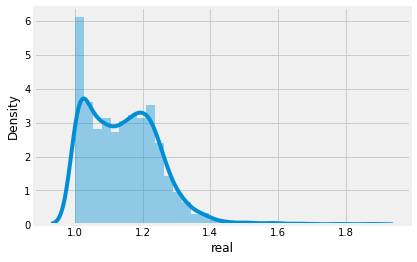

In [27]:
sns.distplot(train['real'])

In [28]:
train.drop(['Hammer_price'],axis=1).corr()['real'].sort_values()

Auction_key                   -0.062983
Current_floor                 -0.055709
Total_floor                   -0.051553
Minimum_sales_price           -0.042232
point.x                       -0.039527
road_bunji1                   -0.021469
addr_bunji2                   -0.002634
Total_land_gross_area          0.006978
addr_bunji1                    0.013455
Total_appraisal_price          0.020108
Total_building_area            0.025305
Total_building_auction_area    0.027848
point.y                        0.038295
road_bunji2                    0.047078
Total_land_real_area           0.059067
Total_land_auction_area        0.060240
Claim_price                    0.104271
Auction_count                  0.356021
Auction_miscarriage_count      0.381825
real                           1.000000
Name: real, dtype: float64

```python
cop=train.copy()
cop['x']=pd.cut(train['point.x'],100)
cop['y']=pd.cut(train['point.y'],100)
cop1=cop.groupby(['x','y']).size().reset_index(name='count')
cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
cop=pd.merge(cop1,cop2,on=['x','y'],how='left')

cop=cop.loc[cop['count']>=9]
area = cop.pivot("y", "x", "real")
plt.subplots(1, 1, figsize=(7, 5))
plt.title("real by area")
sns.heatmap(area, annot=False, xticklabels=False,yticklabels=False,cmap="Blues")
plt.show()
```
> ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

정수 인덱스가 와야한다고 말하는  것 같음.
area의 인덱스는 CategoricalIndex

> 공유 코드 In\[22\]

![heatmap_image](./heatmap_image.png)

위도와 경도를 100개로 나누어서 각 grid 안의 real 값을 평균을 내서 heatmap으로 그려 보았다 (단 각 grid 안에 object가 9개 이상인 grid들만 뽑았다) 예상외로 지역별 real값의 차이가 있어 보인다. 범위를 많이 좁히고, 세밀하게 예측하기 위해 'addr_dong'이라는 변수를 모델에 포함시키면 좋겠다(물론 point.x와 point.y도 있지만 그걸로는 부족해 보인다)

In [29]:
cop=train.copy()

In [30]:
cop['x'] = pd.cut(train['point.x'], 100)
cop['x'].head()

0    (129.134, 129.158]
1    (129.134, 129.158]
2    (128.987, 129.011]
3    (129.085, 129.109]
4    (128.987, 129.011]
Name: x, dtype: category
Categories (100, interval[float64]): [(126.807, 126.834] < (126.834, 126.858] < (126.858, 126.883] < (126.883, 126.907] ... (129.158, 129.182] < (129.182, 129.207] < (129.207, 129.231] < (129.231, 129.256]]

In [31]:
cop['y']=pd.cut(train['point.y'],100)

In [32]:
cop.groupby(['x', 'y']).size()

x                   y               
(126.807, 126.834]  (35.049, 35.078]    0
                    (35.078, 35.104]    0
                    (35.104, 35.13]     0
                    (35.13, 35.157]     0
                    (35.157, 35.183]    0
                                       ..
(129.231, 129.256]  (37.554, 37.58]     0
                    (37.58, 37.607]     0
                    (37.607, 37.633]    0
                    (37.633, 37.659]    0
                    (37.659, 37.686]    0
Length: 10000, dtype: int64

In [33]:
cop.groupby(['x', 'y']).size().sort_values()

x                   y               
(126.807, 126.834]  (35.049, 35.078]     0
(128.424, 128.449]  (35.605, 35.631]     0
                    (35.631, 35.657]     0
                    (35.657, 35.684]     0
                    (35.684, 35.71]      0
                                        ..
(127.005, 127.03]   (37.475, 37.501]    31
(127.03, 127.054]   (37.633, 37.659]    35
(128.962, 128.987]  (35.049, 35.078]    38
(126.956, 126.981]  (37.554, 37.58]     41
(127.054, 127.079]  (37.633, 37.659]    45
Length: 10000, dtype: int64

In [34]:
cop1 = cop.groupby(['x','y']).size().reset_index(name='count')
cop1.head()

,x,y,count
0,"(126.807, 126.834]","(35.049, 35.078]",0
1,"(126.807, 126.834]","(35.078, 35.104]",0
2,"(126.807, 126.834]","(35.104, 35.13]",0
3,"(126.807, 126.834]","(35.13, 35.157]",0
4,"(126.807, 126.834]","(35.157, 35.183]",0


In [35]:
cop1.sort_values(by='count')

,x,y,count
0,"(126.807, 126.834]","(35.049, 35.078]",0
6621,"(128.424, 128.449]","(35.605, 35.631]",0
6622,"(128.424, 128.449]","(35.631, 35.657]",0
6623,"(128.424, 128.449]","(35.657, 35.684]",0
6624,"(128.424, 128.449]","(35.684, 35.71]",0
...,...,...,...
892,"(127.005, 127.03]","(37.475, 37.501]",31
998,"(127.03, 127.054]","(37.633, 37.659]",35
8800,"(128.962, 128.987]","(35.049, 35.078]",38
695,"(126.956, 126.981]","(37.554, 37.58]",41


In [36]:
# mean()에서 값이 NaN이 된다... 왜?
# cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
# cop2

In [37]:
# NaN이 포함되어 있어서 값이 이상해진건지 확인해봄... 없었음 NaN이 포함되어 있어서 값이 이상해진건지 확인해봄... 없었음
# 일단 다음으로 넘어가자..
(cop.groupby(['x','y'])['real'].value_counts() == np.NaN).value_counts()
# 일단 다음으로 넘어가자..
(cop.groupby(['x','y'])['real'].value_counts() == np.NaN).value_counts()

False    1918
Name: real, dtype: int64

In [38]:
# area에 대해 보이기 위해 실행해본거
cop=train.copy()
cop['x']=pd.cut(train['point.x'],100)
cop['y']=pd.cut(train['point.y'],100)
cop1=cop.groupby(['x','y']).size().reset_index(name='count')
cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
cop=pd.merge(cop1,cop2,on=['x','y'],how='left')

cop=cop.loc[cop['count']>=9]
area = cop.pivot("y", "x", "real")
type(area.index)

pandas.core.indexes.category.CategoricalIndex

In [39]:
area

x,"(126.807, 126.834]","(126.834, 126.858]","(126.858, 126.883]","(126.883, 126.907]","(126.907, 126.932]","(126.932, 126.956]","(126.956, 126.981]","(126.981, 127.005]","(127.005, 127.03]","(127.03, 127.054]",...,"(128.889, 128.913]","(128.962, 128.987]","(128.987, 129.011]","(129.011, 129.036]","(129.036, 129.06]","(129.06, 129.085]","(129.085, 129.109]","(129.109, 129.134]","(129.134, 129.158]","(129.158, 129.182]"
y,,,,,,,,,,,,,,,,,,,,,
"(37.554, 37.58]",1.106657,1.149220,NaN,NaN,1.121964,NaN,1.060731,NaN,1.144292,1.111321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.501, 37.528]",NaN,1.138617,1.193049,1.137292,1.098834,1.157545,1.177032,NaN,1.182147,1.138632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.528, 37.554]",NaN,1.138008,1.122478,1.126222,NaN,1.148510,NaN,NaN,1.163593,1.170208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.475, 37.501]",NaN,NaN,1.136653,1.199714,1.187032,1.113097,1.176441,1.150346,1.132009,1.136927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.448, 37.475]",NaN,NaN,NaN,1.153982,1.130363,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.58, 37.607]",NaN,NaN,NaN,1.118953,1.190174,1.148453,NaN,NaN,1.159431,1.129985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.607, 37.633]",NaN,NaN,NaN,NaN,1.114928,NaN,NaN,NaN,1.155724,1.166772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.633, 37.659]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123297,1.146984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(37.659, 37.686]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.144668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
train['addr_dong'].nunique()

285

보다시피 addr_dong은 총 285개의 unique한 값들을 가지고 있고, 그에 비해 우리가 가지고 있는 데이터셋은 너무 적다 (데이터셋이 좀 더 크면 catboost같이 범주형 데이터를 잘 다루어주는 모델도 사용해보았을 것이다) - 위치적인 요소들을 고려해줄 수 있는 외부데이터가 필요해 보인다.

이번에는 각각 close_date과 final_auction_date, first_auction_date과 appraisal_date, final_auction_date과 first_auction_date간의 차이(날 차이)를 변수로 만들어 보았다.


In [41]:
# errors 매개변수
# pd.to_datetime(train['Close_date']) 하면 1111-11-11 00:00:00 으로인해 에러가 뜬다.
# If ‘coerce’, then invalid parsing will be set as NaT.
pd.to_datetime(train['Close_date'], errors='coerce')[train['Close_date']=='1111-11-11 00:00:00']

962    NaT
1016   NaT
1026   NaT
1040   NaT
1146   NaT
1407   NaT
1438   NaT
1627   NaT
1640   NaT
1665   NaT
1867   NaT
1924   NaT
Name: Close_date, dtype: datetime64[ns]

In [42]:
# DateFrame에서 문자열 메소드를 쓰기 위해 .str 쓰는 것 처럼
# datetime 메소드 쓰기위해 .dt 사용하는 듯
(pd.to_datetime(train['Close_date'], errors='coerce') \
                   - pd.to_datetime(train['Final_auction_date'], errors='coerce')).dt.days

0       86.0
1       56.0
2       61.0
3       55.0
4       62.0
        ... 
1928    72.0
1929    72.0
1930    70.0
1931    71.0
1932    92.0
Length: 1932, dtype: float64

In [43]:
train['daydiff1'] = (pd.to_datetime(train['Close_date'], errors='coerce') \
                   - pd.to_datetime(train['Final_auction_date'], errors='coerce')).dt.days
train['daydiff1'] = np.where(train['daydiff1'].isnull(), train['daydiff1'].mean(), train['daydiff1'])

train['daydiff']=(pd.to_datetime(train['First_auction_date'],errors='coerce') \
                  - pd.to_datetime(train['Appraisal_date'],errors='coerce')).dt.days

train['daydiff']=np.where(train['daydiff']<0,train['daydiff'].median(),train['daydiff'])
train['daydiff2']=(pd.to_datetime(train['Final_auction_date'],errors='coerce')\
                   -pd.to_datetime(train['First_auction_date'],errors='coerce')).dt.days

test['daydiff1']=(pd.to_datetime(test['Close_date'],errors='coerce') \
                  - pd.to_datetime(test['Final_auction_date'],errors='coerce')).dt.days
test['daydiff1'] = np.where(test['daydiff1'].isnull(), test['daydiff1'].mean(), test['daydiff1'])

test['daydiff']=(pd.to_datetime(test['First_auction_date'],errors='coerce') \
                 - pd.to_datetime(test['Appraisal_date'],errors='coerce')).dt.days

test['daydiff']=np.where(test['daydiff'] > 0,test['daydiff'].median(),test['daydiff'])
test['daydiff2']=(pd.to_datetime(test['Final_auction_date'],errors='coerce') \
                  - pd.to_datetime(test['First_auction_date'],errors='coerce')).dt.days

In [44]:
#Regist_date을 datetime 형태로 변환
regist['Regist_date'] = pd.to_datetime(regist['Regist_date'].astype('str').str.slice(0,4)\
                                       + "-"+regist['Regist_date'].astype('str').str.slice(4,6)\
                                       + "-"+regist['Regist_date'].astype('str').str.slice(6,8),
                                       errors='coerce')

In [45]:
#Auction_date와 Rent_date를 datetime 형태로 변환
result['Auction_date']=pd.to_datetime(result['Auction_date'])
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')

In [46]:
#regist(등기부등본)에 써져 있는 등기 중 가장 일찍 등기된 것을 고른다 ==> 가장 일찍 등기된 날짜가 건설작업완료 날짜의 추정치이다.
#built_date이라는 변수는 건설작업완료 추정 년도를, built_date는 그 년도가 2000년을 넘기는지 아닌지를 가르키는 변수이다.
train['built_date']=train.apply(lambda x: \
  regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
train['built_date']=pd.DatetimeIndex(train['built_date']).year
train['built_date']=np.where(train['built_date'].isnull(), train['built_date'].median(), train['built_date'])

train['built_date1'] = train['built_date'] <= 2000



test['built_date']=test.apply(lambda x: \
  regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
test['built_date']=pd.DatetimeIndex(test['built_date']).year
test['built_date']=np.where(test['built_date'].isnull(),test['built_date'].median(),test['built_date'])

test['built_date1']=test['built_date'] <= 2000

우리는 Hammer_price/Minimum_price를 타겟으로 놓고 모델을 training시킬 것이므로, Minimum_sales_price나 Total_appraisal_price같이 그냥 단순 금액치보다는 비율적인 정보가 더 중요하다. 그래서 일단 falld(Minimum_sales_price/Total_appraisal_price)라는 변수를 만든다. 그리고 최저경매가가 유찰이 진행될 수록 감정가의 80% ,64% ,51.2%,41%,32.8%, 26.2%, 21%, 16.8%, 13.4% 이런 식으로 떨어지기 때문에 lastupp, 낙찰되기 직전의 유찰된 경매에서의 Minimum_sales_price / Total_appraisal_price,이라는 변수를 생성한다.

예를 들어 감정 평가액이 10억이고 4번 유찰되어 최저경매가가 4.1억이면, falld는 4.1억/10억==0.41이 될 것이고, 낙찰되기 이전, 즉 3번 유찰되었던 시점에 최저경매가는 5.12억이므로 lastupp은 5.21/10==0.521이 될 것이다.

upp은 lastupp/falld를 한 것이고, lastupp_p는 lastupp에서 Total_appraisal_price를 곱한 값이다.

이렇게 단순금액보다는 비율적인 요소를 더 잘 나타낼 수 있는 변수들을 집중적으로 생성해내었고 모델의 정확도 상승에도 큰 도움을 주었다.

In [47]:
train['falld']=(train['Minimum_sales_price']/train['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

train['lastupp']=train.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)


test['falld']=(test['Minimum_sales_price']/test['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

test['lastupp']=test.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)

train['upp']=train['lastupp']/train['falld']
test['upp']=test['lastupp']/test['falld']

train['lastupp_p']=train['lastupp']*train['Total_appraisal_price']
test['lastupp_p']=test['lastupp']*test['Total_appraisal_price']

In [48]:
train['one']=train['Auction_miscarriage_count']==0
test['one']=test['Auction_miscarriage_count']==0

In [49]:
apartname=pd.Series(["더샵","자이","아이파크","래미안","힐스테이트"])

아파트의 브랜드가치도 경매시장에 영향을 줄 수 있을 것이다. 우리나라 대표 아파트 브랜드 5곳(더샵, 자이, 아이파크, 래미안, 힐스테이트)을 뽑아서 addr_etc에서 이 단어의 포함유무를 통해 아파트의 브랜드 변수(apart)를 만든다. 만약 위의 5가지 중 어느 곳에도 포함되어 있지 않는다면 other도 대체한다.

In [50]:
# np.asscalar -> size 1 인 array를 스칼라로
def get_apartname(string_val,apartname):
    if apartname.apply(lambda x: [x in y for y in [string_val]][0]).sum()>0:
        # np.asscalar -> size 1 인 array를 스칼라로
        return np.asscalar(apartname.loc[apartname.apply(lambda x: [x in y for y in [string_val]][0])])
    else:
        return "other"

In [51]:
train['apart']=train.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)
test['apart']=test.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)

In [52]:
namecred=pd.Series(train['Creditor'].value_counts().head().index.tolist())
namecred

0    Private
1       국민은행
2       우리은행
3     중소기업은행
4       하나은행
dtype: object

In [53]:
def getcred(string_val,namecred):
    if namecred.isin([string_val]).sum()>0:
        return np.asscalar(namecred.loc[namecred.isin([string_val])])
    else:
        return "other"
        
train['cred']=train.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)
test['cred']=test.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)

In [54]:
#경매에서 권리의 인수여부는 말소기준권리를 기준으로 결정된다.
#말소기준권리는 저당,압류, 가압 중에서 가장 먼저 일어난 것이며, 각각의 Auction_key마다 이것을 찾아 malsogijun이라는 데이터프레임을 만들었다.
regist['Regist_class']=regist['Regist_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_class']=rent['Rent_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')
malsogijun=regist.loc[pd.Series(regist['Regist_class']).isin(["저당","압류","가압"]),].groupby(['Auction_key'])['Regist_date'].min().reset_index()

In [55]:
#이 말소기준보다 전에 일어나고 점유하고 있는 임차인(대항력을 가진 임차인)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 take_over_rent라는 변수에 저장한다
def get_rent_malso(Rent_date,Auction_key,Rent_class):
    #if pd.isnull(Rent_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
    #    return np.nan
    #else:
    return (#np.asscalar((Rent_date<malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (Rent_class=="점유"))



k=rent.apply(lambda x: get_rent_malso(Rent_date=x['Rent_date'],Auction_key=x['Auctiuon_key'],Rent_class=x['Rent_class']),axis=1)

rent['k']=k
k=rent.loc[rent['k']==True,].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
k.columns=['Auction_key','take_over_rent']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_rent']=np.where(train['take_over_rent'].isnull(),0,train['take_over_rent'])
test['take_over_rent']=np.where(test['take_over_rent'].isnull(),0,test['take_over_rent'])

In [56]:
#등기부등본 상에서도 말소기준 권리 이전에 일어난 모든 권리행위의 Regist_price를 더해 take_over_regist라는 변수를 만든다.
def get_regist_malso(Regist_date,Auction_key,Regist_class):
        if pd.isnull(Regist_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
            return np.nan
        else:
            return (np.asscalar((Regist_date<malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (pd.Series(Regist_class).isin(["전세권","임차권","가등기"])))



k=regist.apply(lambda x: get_regist_malso(Regist_date=x['Regist_date'],Auction_key=x['Auction_key'],Regist_class=x['Regist_class']),axis=1)

regist['k']=k
k=regist.loc[regist['k']==True,].groupby(['Auction_key'])['Regist_price'].sum().reset_index()
k.columns=['Auction_key','take_over_regist']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_regist']=np.where(train['take_over_regist'].isnull(),0,train['take_over_regist'])
test['take_over_regist']=np.where(test['take_over_regist'].isnull(),0,test['take_over_regist'])

In [57]:
train['take_over_sum']=train['take_over_regist']+train['take_over_rent']
test['take_over_sum']=test['take_over_regist']+test['take_over_rent']

In [58]:
a=regist.apply(lambda x: pd.Series(x['Regist_class']).isin(['전세권','가등기','임차권']),axis=1)
a.columns=['a']

regist1=regist.loc[a['a'],]

def get_badang(Auction_key,a=regist1):
    return len(a.loc[a['Auction_key']==Auction_key,])
    
train['badang']=train.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)
test['badang']=test.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)

In [59]:
#등기부등본(regist) 상의 전세권, 가등기, 임차권을 가지고 있는 사람의 명수를 더해 badang이라는 변수에 저장한다.
# 이 변수는 낙찰이 되었을 때 해당 금액을 배당받을 수 있는 사람들의 명수를 의미한다.

In [60]:
train['is_rent']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
test['is_rent']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
train['is_regist']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)
test['is_regist']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)

In [61]:
#regist나 rent에 대한 정보가 있는 것이 오히려 real값이 적어지는 경향이 있는 것을 알 수 있다.
train['floor_rate']=train['Current_floor']/train['Total_floor']
test['floor_rate']=test['Current_floor']/test['Total_floor']

In [62]:
#해당 방의 층을 아파트의 전체 층으로 나눈 층의 비율을 floor_rate 라는 변수로 만듦.
#아파트마다 층이 다르므로, 이를 비교하기위한 normalization 과정이라 할 수 있다.
result1=result.loc[result['Auction_results']=="낙찰",]

a=result1.groupby(['Auction_key'])['Auction_results'].count().reset_index()
a['Auction_results']=a['Auction_results']>1
a.columns=['Auction_key','is_re']
train=pd.merge(train,a,how='left')
test=pd.merge(test,a,how='left')

이하 아래의 내용은 따로 데이터를 받아와서 추가적으로 또 전처리 해주는 작업들...